# LSTM with autoencoder outliner detection

https://github.com/BLarzalere/LSTM-Autoencoder-for-Anomaly-Detection/blob/master/Sensor%20Anomaly%20Detection.ipynb

https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/14.time-series-anomaly-detection.ipynb

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: /content/spx.csv
100% 152k/152k [00:00<00:00, 56.5MB/s]


In [66]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')


#calc the moving average
df['SMA_Temp']=df['close'].rolling(window = 200, min_periods = 1).mean()

df.shape

(8192, 2)

In [67]:
df.tail()

,close,SMA_Temp
date,,
2018-06-25,2717.07,2664.41680
2018-06-26,2723.06,2665.72495
2018-06-27,2699.63,2666.78255
2018-06-28,2716.31,2667.88170
2018-06-29,2718.37,2668.98170


In [68]:
# calc std. deviation and mean
std_x_train=np.std(df["close"])
mean_x_train=np.mean(df["close"])

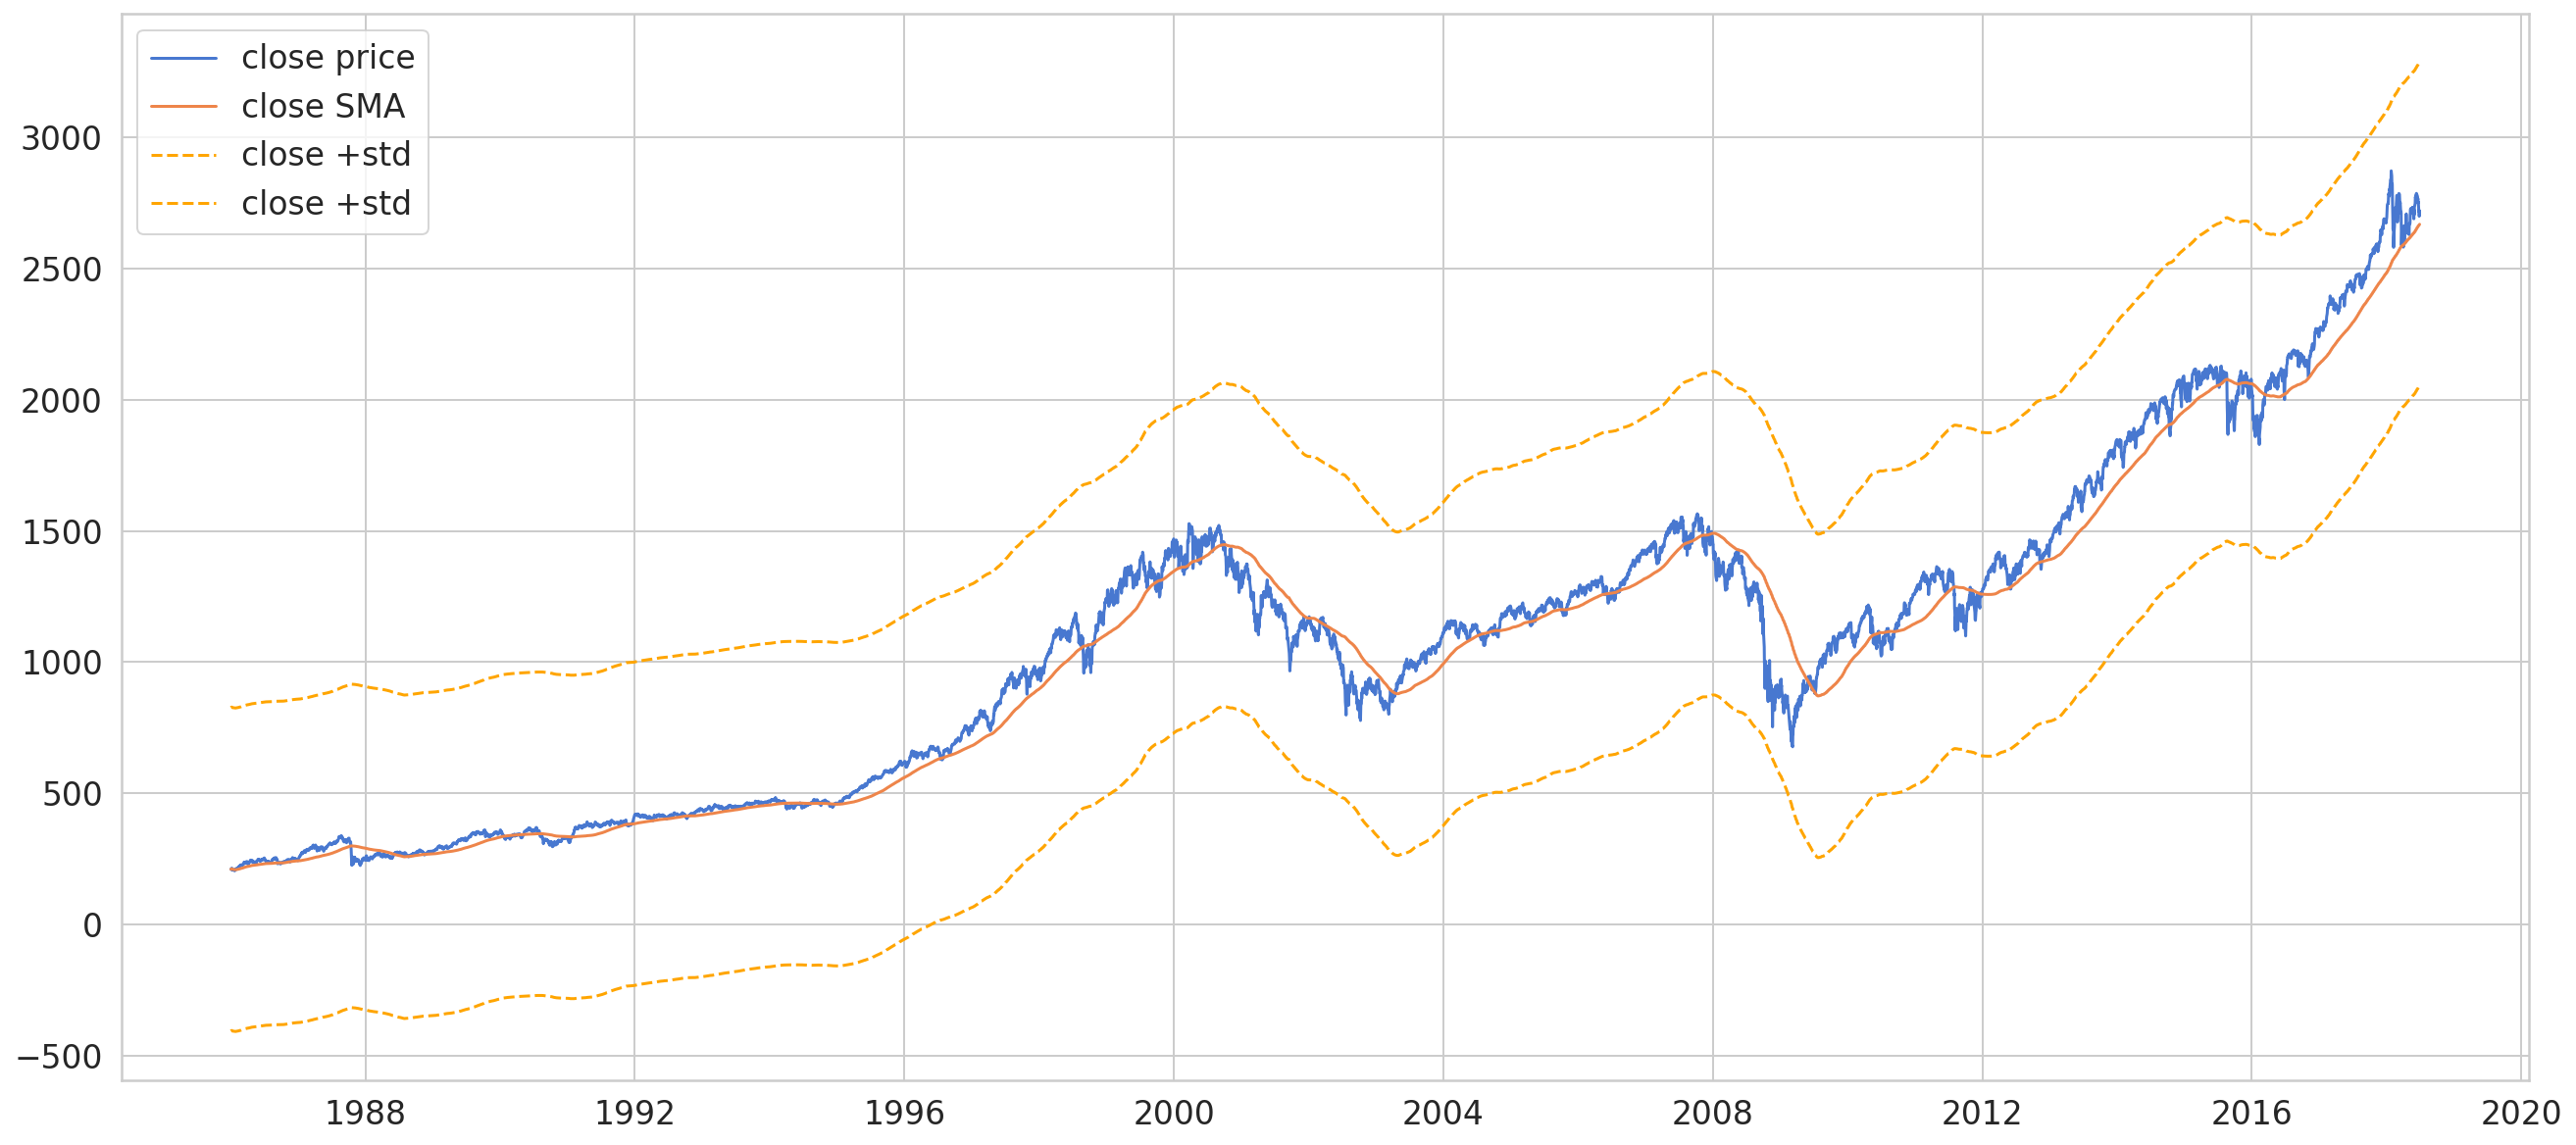

In [69]:
rcParams['figure.figsize'] = 22, 10
import matplotlib.pyplot as plt

plt.plot(df.index,df["close"], label='close price')
plt.plot(df.index,df["SMA_Temp"] ,label='close SMA')

plt.plot(df.index,df["SMA_Temp"]+ std_x_train,label='close +std' , color="orange",linestyle='dashed')
plt.plot(df.index,df["SMA_Temp"]- std_x_train,label='close +std', color="orange",linestyle='dashed')

plt.legend();

In [6]:
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 1) (1639, 1)


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [9]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(6523, 30, 1)


In [10]:
  ''' inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)

    '''

" inputs = Input(shape=(X.shape[1], X.shape[2]))\n  L1 = LSTM(16, activation='relu', return_sequences=True, \n            kernel_regularizer=regularizers.l2(0.00))(inputs)\n  L2 = LSTM(4, activation='relu', return_sequences=False)(L1)\n  L3 = RepeatVector(X.shape[1])(L2)\n  L4 = LSTM(4, activation='relu', return_sequences=True)(L3)\n  L5 = LSTM(16, activation='relu', return_sequences=True)(L4)\n  output = TimeDistributed(Dense(X.shape[2]))(L5)    \n  model = Model(inputs=inputs, outputs=output)\n\n  "

## create the model

### option 1:

In [11]:
'''
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2]),activation='relu'
))
model.add(keras.layers.Dropout(rate=0.2))

#model.add(keras.layers.LSTM(units=16, activation='relu'))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))

#model.add(keras.layers.LSTM(units=16, return_sequences=True,activation='relu'))
model.add(keras.layers.LSTM(units=64, return_sequences=True,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))

model.compile(loss='mae', optimizer='adam', metrics="accuracy")

'''

'\nmodel = keras.Sequential()\nmodel.add(keras.layers.LSTM(\n    units=64, \n    input_shape=(X_train.shape[1], X_train.shape[2]),activation=\'relu\'\n))\nmodel.add(keras.layers.Dropout(rate=0.2))\n\n#model.add(keras.layers.LSTM(units=16, activation=\'relu\'))\nmodel.add(keras.layers.RepeatVector(n=X_train.shape[1]))\n\n#model.add(keras.layers.LSTM(units=16, return_sequences=True,activation=\'relu\'))\nmodel.add(keras.layers.LSTM(units=64, return_sequences=True,activation=\'relu\'))\nmodel.add(keras.layers.Dropout(rate=0.2))\nmodel.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))\n\nmodel.compile(loss=\'mae\', optimizer=\'adam\', metrics="accuracy")\n\n'

### option2:

In [12]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))

model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
184/184 [==============================] - 36s 23ms/step - loss: 0.3013 - val_loss: 0.1109
Epoch 2/10
184/184 [==============================] - 3s 17ms/step - loss: 0.1720 - val_loss: 0.0764
Epoch 3/10
184/184 [==============================] - 3s 17ms/step - loss: 0.1366 - val_loss: 0.0645
Epoch 4/10
184/184 [==============================] - 3s 17ms/step - loss: 0.1268 - val_loss: 0.0486
Epoch 5/10
184/184 [==============================] - 3s 17ms/step - loss: 0.1150 - val_loss: 0.0421
Epoch 6/10
184/184 [==============================] - 3s 17ms/step - loss: 0.1145 - val_loss: 0.0531
Epoch 7/10
184/184 [==============================] - 3s 17ms/step - loss: 0.1073 - val_loss: 0.0383
Epoch 8/10
184/184 [==============================] - 3s 17ms/step - loss: 0.1020 - val_loss: 0.0427
Epoch 9/10
184/184 [==============================] - 3s 17ms/step - loss: 0.0999 - val_loss: 0.0547
Epoch 10/10
184/184 [==============================] - 3s 17ms/step - loss: 0.1013 - val_l

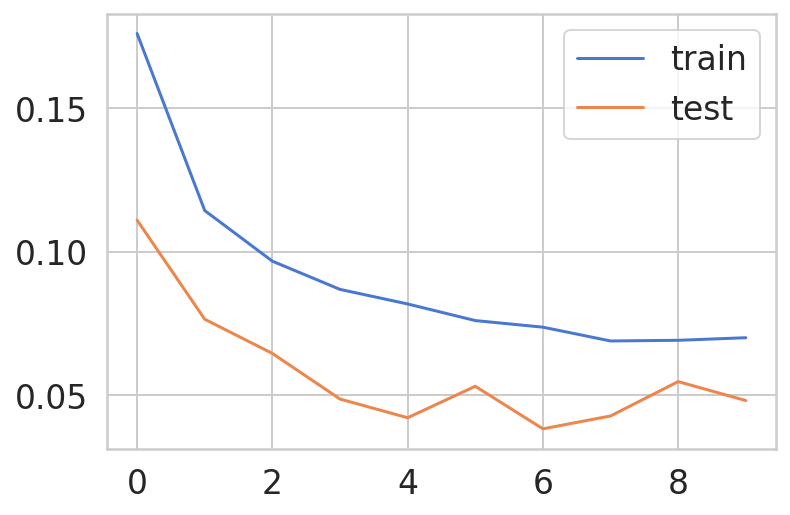

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

## calc the loss between ypred - ytest

In [15]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


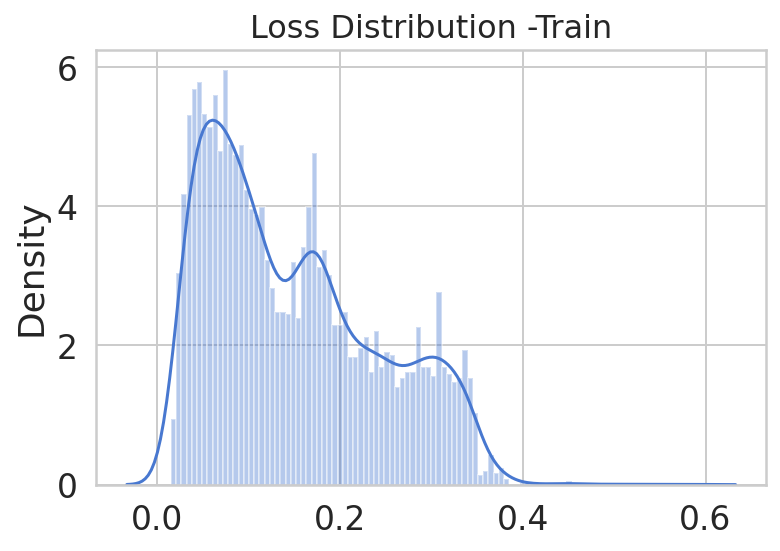

In [16]:
plt.title('Loss Distribution -Train', fontsize=16)
sns.distplot(train_mae_loss, bins=100, kde=True);

In [17]:
X_test_pred = model.predict(X_test)


test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


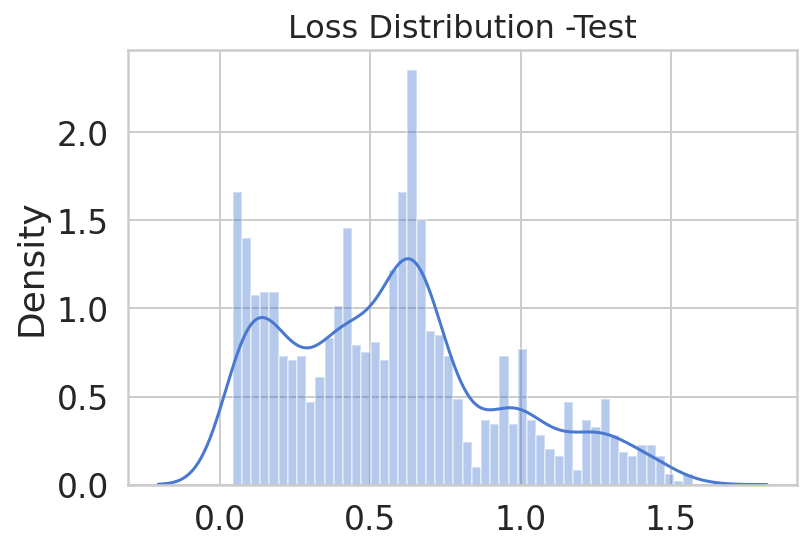

In [18]:
plt.title('Loss Distribution -Test', fontsize=16)
sns.distplot(test_mae_loss, bins=50, kde=True);

## calc threshold with std. deviation

In [19]:




test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss

#calculate threshold by std deviation *3

std_x_train=np.std(test_score_df.loss)*3
mean_x_train=np.mean(test_score_df.loss)

THRESHOLD = std_x_train

test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

THRESHOLD

1.0837908128697904

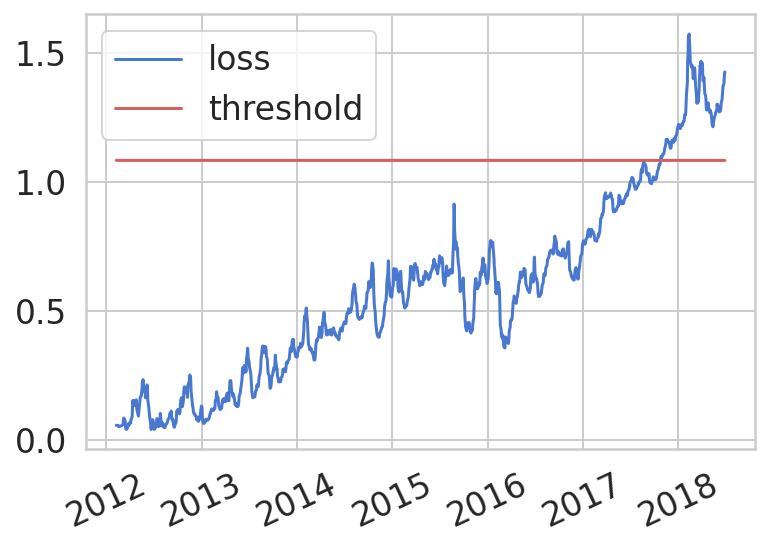

In [20]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold', color="r")
plt.xticks(rotation=25)
plt.legend();

## print and plot the anomalies

In [21]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head(30)

,loss,threshold,anomaly,close
date,,,,
2017-10-26,1.091759,1.083791,True,4.117757
2017-10-27,1.099285,1.083791,True,4.167294
2017-10-30,1.094151,1.083791,True,4.147547
2017-10-31,1.097414,1.083791,True,4.153370
2017-11-01,1.100956,1.083791,True,4.163196
2017-11-02,1.103262,1.083791,True,4.164371
2017-11-03,1.107507,1.083791,True,4.183519
2017-11-06,1.108622,1.083791,True,4.191404
2017-11-07,1.110980,1.083791,True,4.190230


In [22]:
anomalies.count()

loss         170
threshold    170
anomaly      170
close        170
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


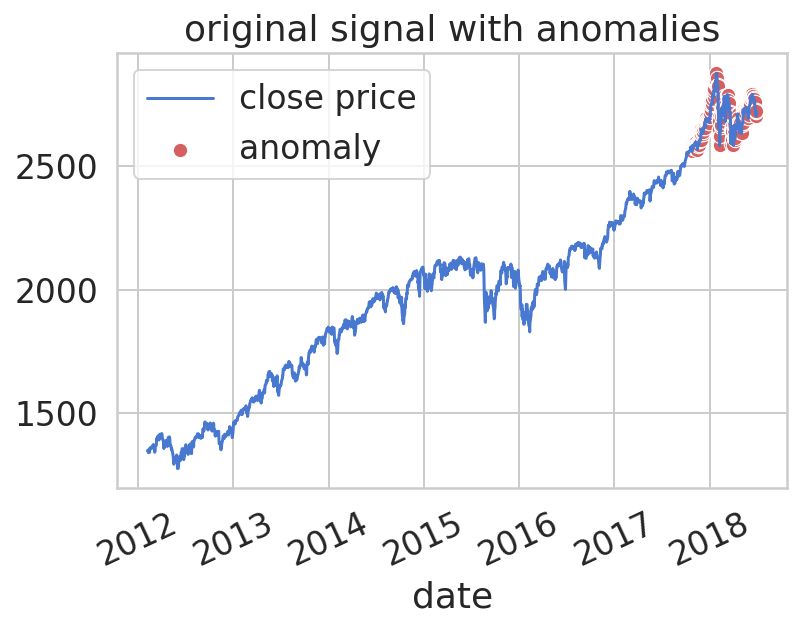

In [23]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.title('original signal with anomalies')
plt.legend();